In [1]:
## Environment and packages
using Pkg; Pkg.activate("../../."); 
# Pkg.instantiate()

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


In [2]:
using HDF5
using JLD
using LinearAlgebra
using Statistics
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio
using Plots; gr()

Plots.GRBackend()

In [45]:
#nx, ny = 100, 100 # Size of the grid This are defined later 

# these in should be 50m, but we are using 1 in MWE_iceflow.jl
Δx, Δy = 50, 50 # meters 
Δt = 1.0/12.0 # timestep in years
t = 0
t₁ = 3

# Numerical method parameters
tolnl = 1e-2
itMax = 60
damp = 0.85
dτsc   = 1.0/2.0
ϵ     = 1e-4            # small number
#nout = 25                # error check frequency
cfl  = max(Δx^2,Δy^2)/4.1
D_max = 200000 # maximum value of expected diffusivity

# Glacier parameters 

# minimum and maximum possible values for A (check with bib)
Amin = 1e-17 / 2
Amax = 1e-16
ρ = 900 # wrong units? Should it be 900 kg/m^3?
g = 9.81
n = 3

3

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


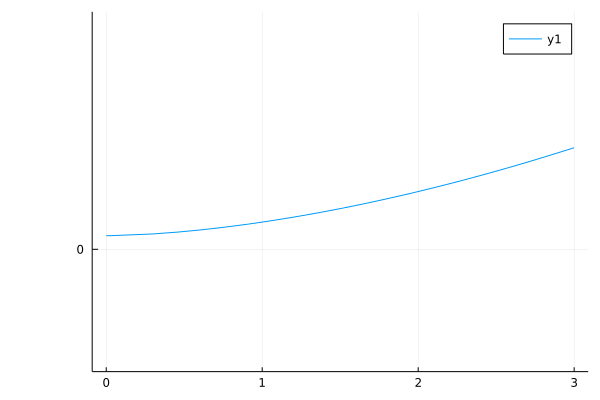

In [4]:
fakeA(t) = (1 + t^1.7)*1e-17
plot(fakeA, 0, t₁)

In [9]:
@views avg(A) = 0.25 * ( A[1:end-1,1:end-1] .+ A[2:end,1:end-1] .+ A[1:end-1,2:end] .+ A[2:end,2:end] )
@views avg_x(A) = 0.5 .* ( A[1:end-1,:] .+ A[2:end,:] )
@views avg_y(A) = 0.5 .* ( A[:,1:end-1] .+ A[:,2:end] )

avg_y (generic function with 1 method)

In [10]:
function iceflow!(H,t,t₁)

    println("Running forward PDE ice flow model...\n")
    # Instantiate variables
    
    let             

    total_iter = 0
    ts_i = 1

    # Manual explicit forward scheme implementation
    while t < t₁
            
        let
        iter = 1
        err = 10e10
        Hold = copy(H) # hold value of H for the other iteration in the implicit method
        dHdt = zeros(nx, ny) # with Tullio

        # Get current year for MB and ELA
        year = floor(Int, t) + 1

        A = fakeA(t)

        while iter < itMax+1

            Err = copy(H)

            # Compute the Shallow Ice Approximation in a staggered grid
            F, dτ = SIA(H, A)

            # implicit method with Tullio  
            @tullio ResH[i,j] := -(H[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dHdt_ = copy(dHdt)
            @tullio dHdt[i,j] := dHdt_[i,j]*damp + ResH[i,j]

            H_ = copy(H)
            @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ)# [pad(i-1,1,1),pad(j-1,1,1)]) 


            # Error assertion
            Err = Err .- H
            err = maximum(Err)
                  
            if isnan(err)
                error("""NaNs encountered.  Try a combination of:
                            decreasing `damp` and/or `dtausc`, more smoothing steps""")
            elseif err>10e8
                error("""Inestability detected""")
            elseif iter == itMax && err > tolnl
                error("""Desired convergence tolerance don't reached. Increase the number of iterations
                            itMax or decrease the tolerance tolnl. Current error after $iter iterations is $err""")            
            end

            iter += 1
            total_iter += 1
                                        
        end

        t += Δt

        end

    end 

    #println("Total Number of iterartions: ", total_iter)
    end

    println("Saving reference data")
    save(joinpath(root_dir, "data/H_ref.jld"), "H", H)

    return H
end

iceflow! (generic function with 1 method)

In [12]:
function SIA(H, A)
    
    # Update glacier surface altimetry
    S = B .+ H
    
    # All grid variables computed in a staggered grid
    # Compute surface gradients on edges
    dSdx  = diff(S, dims=1) / Δx
    dSdy  = diff(S, dims=2) / Δy
    #∇S = sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)  # this does not work
    norm∇S² = avg_y(dSdx).^2 .+ avg_x(dSdy).^2


    Γ = 2 * A * (ρ * g)^n / (n+2)
    
    #println("nablaS max: ", maximum(∇S))
    D = Γ .* avg(H).^(n + 2) .* norm∇S².^((n - 1)/2)
    #D = Γ .* avg(H).^(n + 2) .* ∇S.^(n - 1) # this does not work
    #D = Γ .* avg(H).^(n + 2) .* 2.5^(n - 1) # hardcoded version

  
    # Compute flux components
    dSdx_edges = diff(S[:,2:end - 1], dims=1) / Δx
    dSdy_edges = diff(S[2:end - 1,:], dims=2) / Δy
    Fx = .-avg_y(D) .* dSdx_edges
    Fy = .-avg_x(D) .* dSdy_edges    
    #  Flux divergence
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) # MB to be added here 

    # Compute dτ for the implicit method
    #println("Max dif / D_Max: ", maximum(D) / D_max)
    Zygote.ignore() do 
        maximumD = maximum(D)
        if D_max < maximumD
            error("Upper bound of diffusivity reached. Increase the value of D_max to ensure stability. Current 
                maximum value of D is $maximumD and the upper limit is $D_max")
        end
    end
    
    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D_max))))

    return F, dτ

end

SIA (generic function with 1 method)

### Generate reference dataset

In [13]:
#dataset = 'fake'
dataset = "Argentiere"

if dataset == "fake"

    H₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]
    
elseif dataset == "Argentiere"
    
    root_dir = cd(pwd, "../../.")
    argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres_rcp2.6.h5"), "r")

    mutable struct Glacier
        bed::Array{Float64}    # bedrock height
        thick::Array{Float64}  # ice thickness
        vel::Array{Float64}    # surface velocities
        MB::Array{Float64}     # surface mass balance
        lat::Float64
        lon::Float64
    end
    
    # Fill the Glacier structure with the retrieved data
    argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                         HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["s_apply_hist"])[begin:end-2,:,2:end],
                         0, 0);
    
    nx = size(argentiere.bed)[1]
    ny = size(argentiere.bed)[2]
    
    H₀ = argentiere.thick[:,:,1]
    B  = copy(argentiere.bed)
    
end

193×189 Matrix{Float64}:
 1334.0  1324.0  1310.0  1296.0  1285.0  …  2348.0  2338.0  2326.0  2318.0
 1347.0  1337.0  1320.0  1303.0  1289.0     2318.0  2306.0  2294.0  2284.0
 1362.0  1351.0  1335.0  1316.0  1299.0     2270.0  2260.0  2244.0  2234.0
 1372.0  1364.0  1349.0  1331.0  1313.0     2210.0  2206.0  2194.0  2188.0
 1380.0  1374.0  1362.0  1349.0  1333.0     2150.0  2154.0  2152.0  2150.0
 1385.0  1381.0  1375.0  1366.0  1354.0  …  2108.0  2118.0  2124.0  2126.0
 1389.0  1388.0  1386.0  1382.0  1375.0     2088.0  2098.0  2106.0  2110.0
 1396.0  1396.0  1397.0  1397.0  1394.0     2078.0  2086.0  2094.0  2100.0
 1408.0  1408.0  1409.0  1410.0  1410.0     2074.0  2080.0  2088.0  2094.0
 1424.0  1424.0  1424.0  1425.0  1426.0     2072.0  2078.0  2086.0  2092.0
 1445.0  1444.0  1442.0  1442.0  1444.0  …  2072.0  2076.0  2084.0  2092.0
 1468.0  1465.0  1462.0  1462.0  1466.0     2070.0  2076.0  2084.0  2090.0
 1492.0  1489.0  1485.0  1485.0  1490.0     2072.0  2078.0  2084.0  2090.0


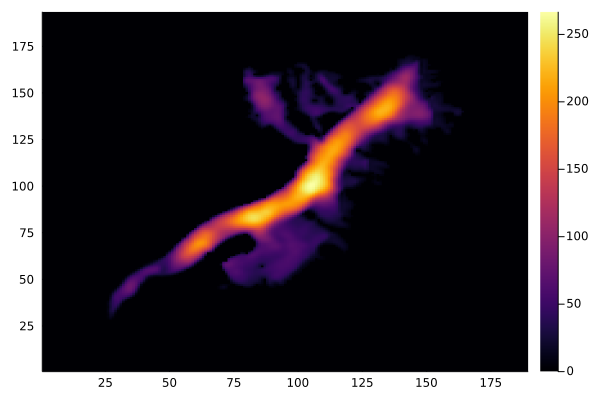

In [14]:
heatmap(H₀, clim=(0, maximum(H₀)))

In [15]:
#reference = "simulate"
reference = "load"

if reference == "simulate"
    # Make simulation for reference training matrix and store it
    H_ref = iceflow!(H₀,t,t₁)
elseif reference == "load"
    # Load stored H ref matrix for training
    H_ref = load(joinpath(root_dir, "data/H_ref.jld"))["H"]
end

193×189 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

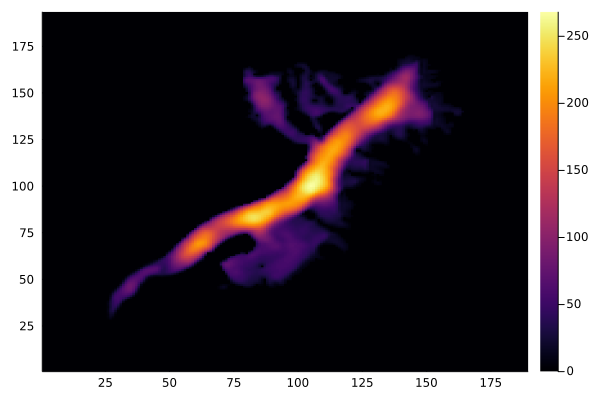

In [16]:
heatmap(H_ref, clim=(0, maximum(H_ref)))

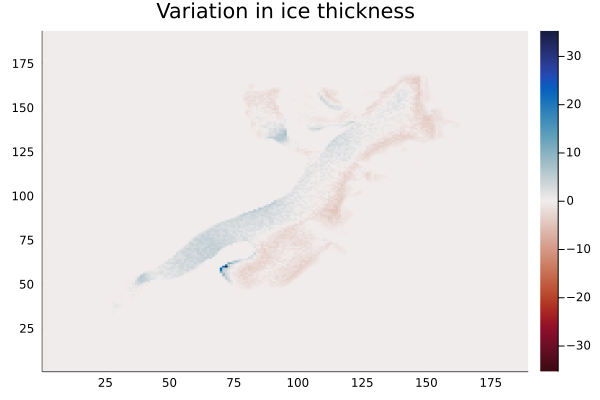

In [17]:
lim = maximum( abs.(H_ref .- H₀) )
heatmap(H_ref .- H₀, c = cgrad(:balance,rev=true),   clim = (-lim, lim), title="Variation in ice thickness")

In [18]:
lim

35.29538750938819

## Learning `A` with an UDE

In [19]:
function iceflow!(H, UA, t, t₁)

    # Retrieve input variables  
    let                  
    current_year = 0
    total_iter = 0
    t = 0

    # Forward scheme implementation
    while t < t₁
        let
        iter = 1
        err = 2 * tolnl
        Hold = copy(H)
        dHdt = zeros(nx, ny)
        err = Inf 

        YA = predict_A(UA, [t])
                
        while iter < itMax+1

            #println("iter: ", iter)
        
            Err = copy(H)

            # Compute the Shallow Ice Approximation in a staggered grid
            F, dτ = SIA(H, YA)


            # Compute the residual ice thickness for the inertia
            @tullio ResH[i,j] := -(H[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dHdt_ = copy(dHdt)
            @tullio dHdt[i,j] := dHdt_[i,j]*damp + ResH[i,j]
                            
            # We keep local copies for tullio
            H_ = copy(H)
            
            # Update the ice thickness
            @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ)
           
            # Error assertion
            Err = Err .- H
            err = maximum(Err)
                  
            if isnan(err)
                error("""NaNs encountered.  Try a combination of:
                            decreasing `damp` and/or `dtausc`, more smoothing steps""")
            elseif err>10e8
                error("""Inestability detected""")
            elseif iter == itMax && err > tolnl
                error("""Desired convergence tolerance don't reached. Increase the number of iterations
                            itMax or decrease the tolerance tolnl. Current error after $iter iterations is $err""")            
            end
            
            iter += 1
            total_iter += 1

        end
        
        t += Δt

        end # let
    end   
    end # let

    return H

end

iceflow! (generic function with 2 methods)

In [20]:
function loss(H, UA, t, t₁)
   
    H = iceflow!(H, UA, t,t₁)

    l_H = sqrt(Flux.Losses.mse(H, H_ref; agg=sum))

    # println("l_A: ", l_A)
    println("Loss in loss(): ", l_H)

    # l = l_A + l_H

    # Zygote.ignore() do    
    #     println("Values of predict_A in loss(): ", predict_A(UA, [0, 1, 2, 3, 4]'))
    #     hml = heatmap(H_ref .- H, title="Loss error")
    #     display(hml)
    # end

    return l_H
end

loss (generic function with 1 method)

In [21]:
function hybrid_train_NN!(UA, opt)
    
    H = copy(H₀)
    # println("Values of UA in hybrid_train BEFORE: ", predict_A(UA, [0, 1, 2, 3, 4]'))

    θ = Flux.params(UA)
    loss_UA, back_UA = Zygote.pullback(() -> loss(H, UA, t, t₁), θ) # with UA

    ∇_UA = back_UA(one(loss_UA)) 
    println("Gradient: ", ∇_UA)
    Flux.Optimise.update!(opt, θ, ∇_UA) # comment line of update of the NN to see if something is happening with the params of UA
    
    println("Loss: ", loss_UA)
    println("Gradient: ", ∇_UA)
    println("Values of predict_A in hybrid_train in hybrid_train(): ", predict_A(UA, [0, 1, 2, 3, 4]')) # Simulations here are all NaNs

    for ps in Flux.params(UA)
        @show ps
        @show ∇_UA[ps]
    end
    
    return loss_UA, ∇_UA, back_UA
    
end

hybrid_train_NN! (generic function with 1 method)

In [51]:
function train!(UA)
   
    @epochs 10 hybrid_train_NN!(UA, opt)
    
    println("Values of predict_A in train(): ", predict_A(UA, [0, 1, 2, 3, 4]'))
    
end

train! (generic function with 1 method)

In [52]:
predict_A(UA, t) = Amin .+ (Amax-Amin) .* sigmoid.(UA((t)))
#predict_A(UA, t) = (1 .+ UA(t)).*1e-16 / 3

predict_A (generic function with 1 method)

We create the NN and we train the UDE

In [53]:
leakyrelu(x, a=0.01) = max(a*x, x)
relu(x) = max(0, x)
#relu2(x) = min(max(0, x), 1)

opt = RMSProp(0.002)

RMSProp(0.002, 0.9, IdDict{Any, Any}())

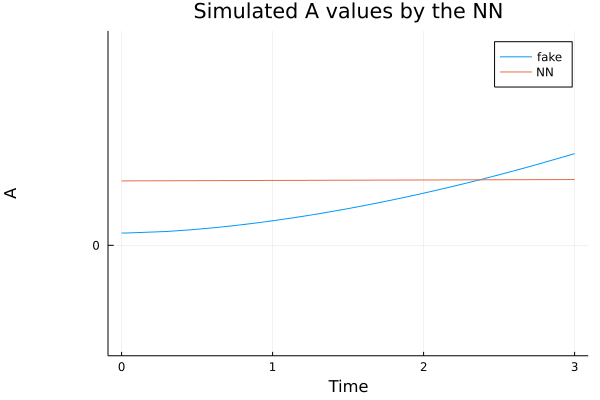

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


In [54]:
UA = Chain(
    Dense(1,10), 
    Dense(10,10, leakyrelu, init = Flux.glorot_normal), 
    Dense(10,5, leakyrelu, init = Flux.glorot_normal), 
    #Dense(10,10, relu2, init = Flux.glorot_normal), 
    #Dense(10,5, relu2, init = Flux.glorot_normal), 
    Dense(5,1) 
)

all_times = LinRange(0, t₁, 50)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(fakeA, 0, t₁, label="fake")
initial_NN = predict_A(UA, all_times')'
plot!(all_times, initial_NN, title="Simulated A values by the NN", yaxis="A", xaxis="Time", label="NN")

In [55]:
debug = "high" # low

if debug == "low"
    # Lower level debugging
    H = copy(H₀)
    θ = Flux.params(UA)
    loss_UA, back_UA = Zygote._pullback(UA -> loss(H, UA, t, t₁), UA) # with UA

    ∇_UA = back_UA(one(loss_UA)) 
    
elseif debug == "high"
    # Higher level debugging
    #loss_UA, ∇_UA, back_UA = hybrid_train_NN!(UA, opt)
    train!(UA)
end

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 75.62853490727818
Gradient: Grads(...)
Loss: 75.62853490727818
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [5.145990822059302e-17 4.871086534065816e-17 4.638436510199553e-17 4.408731858081233e-17 4.183018794771598e-17]
ps = Float32[-0.24359958; 0.3538675; 0.72032994; 0.41532898; 0.51092714; -0.4341848; 0.50942373; -0.009805248; -0.56720054; -0.3214091]
∇_UA[ps] = [0.0063245551111589795; 0.0063245555519252095; 0.006324555370041698; -0.006324555362223657; -0.006324555377141384; -0.0063245553296438555; -0.006324555210917851; -0.006324555235769371; 0.006324555377525624; -0.006324555237008265]
ps = Float32[-0.0063245553, -0.0063245553, -0.0063245557, 0.0063245553, 0.0063245553, 0.006324555, 0.0063245553, 0.0063245553, -0.0063245553, 0.0063245553]
∇_UA[ps] = [0.006324555092007922, 0.006324555249887841, 0.006324555531568346, -0.006324555190470407, -0.006324555223413188, -0.006324554962782952, -0.006324555049209827, -0.006324555214283974, 0.00632

┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 55.827964599806215
Gradient: Grads(...)
Loss: 55.827964599806215
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [5.065152726451016e-17 4.5739748898115624e-17 4.1579526652603127e-17 3.7588983317998625e-17 3.381902123846726e-17]
ps = Float32[-0.24826516; 0.34933335; 0.7158418; 0.42089775; 0.5156312; -0.42991242; 0.5143654; -0.0051114094; -0.5719152; -0.3171567]
∇_UA[ps] = [0.004665587284996317; 0.004534156856375875; 0.004488120676161; -0.005568777386405939; -0.004704044375755987; -0.004272372055076436; -0.004941624689540226; -0.004693838705675216; 0.004714654025048981; -0.004252418760867704]
ps = Float32[-0.011011218, -0.010746069, -0.010745704, 0.012518889, 0.011060037, 0.010555481, 0.011352352, 0.01114327, -0.011213282, 0.010325675]
∇_UA[ps] = [0.004686662856204252, 0.0044215140452894515, 0.004421148363998284, -0.006194334017781582, -0.004735481256791027, -0.004230925588720741, -0.005027796335350495, -0.0048187144534797945, 0.004888726932516

┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 41.59089274704413
Gradient: Grads(...)
Loss: 41.59089274704413
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.99519530570413e-17 4.331992999847172e-17 3.7777954905137805e-17 3.264653262223424e-17 2.80212211157089e-17]
ps = Float32[-0.25214952; 0.34562275; 0.71219647; 0.425741; 0.51956713; -0.42658043; 0.51858735; -0.0011581879; -0.57586956; -0.31385857]
∇_UA[ps] = [0.003884361165274872; 0.0037105934746974986; 0.003645386342811968; -0.004843236007701719; -0.003935961885150955; -0.0033319765685122142; -0.004221962939125294; -0.003953221498487095; 0.003954335877273915; -0.00329814582529393]
ps = Float32[-0.014905879, -0.014397819, -0.014420168, 0.017527208, 0.0150546385, 0.013842184, 0.015626686, 0.015169663, -0.015289439, 0.01338786]
∇_UA[ps] = [0.003894661248382023, 0.0036517490055130533, 0.003674463224003328, -0.0050083186711188735, -0.0039946015465708315, -0.0032867034815540234, -0.0042743335223927904, -0.00402639313523413, 0.00407615698

┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 30.096335777132513
Gradient: Grads(...)
Loss: 30.096335777132513
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.931917868390135e-17 4.124576947474881e-17 3.462426243910525e-17 2.8723961528390933e-17 2.3663346535948662e-17]
ps = Float32[-0.25554463; 0.3424217; 0.70907086; 0.4300501; 0.5230221; -0.42384088; 0.5223397; 0.002358401; -0.57934976; -0.3111676]
∇_UA[ps] = [0.0033951051687360965; 0.0032010247158794666; 0.0031255925646246677; -0.004309105869737592; -0.003454996892528174; -0.002739542898797389; -0.0037523637907609813; -0.003516588771747135; 0.0034801744670496584; -0.0026909781120971667]
ps = Float32[-0.018300934, -0.017553588, -0.017621139, 0.021872118, 0.018581742, 0.016494583, 0.019430857, 0.018746559, -0.018876329, 0.015777012]
∇_UA[ps] = [0.003395054451205792, 0.003155769050328412, 0.003200971059935664, -0.004344911299880584, -0.0035271044320042653, -0.00265239887660641, -0.0038041711497218715, -0.0035768957129871134, 0.00358689

┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 20.404903385430824
Gradient: Grads(...)
Loss: 20.404903385430824
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.872923045852949e-17 3.94187907211312e-17 3.194080567072603e-17 2.5536758995291713e-17 2.0312508873983834e-17]
ps = Float32[-0.25859046; 0.33958328; 0.7063085; 0.43394718; 0.52613556; -0.42154324; 0.52575314; 0.0055822656; -0.5824911; -0.30893505]
∇_UA[ps] = [0.003045829147508811; 0.002838438748497276; 0.002762386049135072; -0.0038970643820677993; -0.003113462940393121; -0.0022976379473087527; -0.0034134535698883287; -0.003223864364948533; 0.0031413658980927765; -0.0022325542490561354]
ps = Float32[-0.02132959, -0.020335851, -0.020471463, 0.025744839, 0.021769607, 0.018599477, 0.022916742, 0.022038247, -0.022125008, 0.017546788]
∇_UA[ps] = [0.0030286550187454174, 0.0027822625296719285, 0.0028503232692077248, -0.0038727200616250675, -0.003187865404832255, -0.002104893153736876, -0.003485884693103763, -0.0032916886922160398, 0.0032

┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 12.05401716897842
Gradient: Grads(...)
Loss: 12.05401716897842
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.8161524613149896e-17 3.7821032172691783e-17 2.9624228060190625e-17 2.2910763280387637e-17 1.76974003068735e-17]
ps = Float32[-0.26136038; 0.33703157; 0.70382386; 0.43750212; 0.5289818; -0.41962206; 0.5289033; 0.008581547; -0.5853666; -0.30709988]
∇_UA[ps] = [0.002769917593194618; 0.0025517082532523537; 0.0024846468047900095; -0.0035549399877122297; -0.0028462267818389533; -0.0019211651718848742; -0.003150190410748829; -0.0029992819456521945; 0.0028755296417072524; -0.0018351530048136594]
ps = Float32[-0.024083138, -0.022835668, -0.023119701, 0.029213404, 0.02471045, 0.02027526, 0.0261491, 0.025118224, -0.025113642, 0.018781718]
∇_UA[ps] = [0.002753548730428376, 0.002499816818377194, 0.0026482375262406616, -0.003468565591779239, -0.0029408431671423497, -0.001675783533567268, -0.003232358391777713, -0.0030799778075921514, 0.00298863

┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 4.772383230480765
Gradient: Grads(...)
Loss: 4.772383230480765
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.7604074967003e-17 3.659625287272013e-17 2.760261116867156e-17 2.0722750817276506e-17 1.56295452096457e-17]
ps = Float32[-0.2638908; 0.33471876; 0.70152515; 0.4407203; 0.5316353; -0.4180126; 0.53182566; 0.011378977; -0.5880544; -0.3056549]
∇_UA[ps] = [0.002530415475536483; 0.0023128097167669204; 0.002298692385848825; -0.003218174881137669; -0.0026534773504078893; -0.0016094660686439201; -0.0029223494953766666; -0.0027974302536206822; 0.002687784308869912; -0.001444956663720903]
ps = Float32[-0.02658281, -0.025102759, -0.02567683, 0.03223043, 0.027523959, 0.021643028, 0.029138276, 0.027974967, -0.027975349, 0.019416079]
∇_UA[ps] = [0.0024996710877960788, 0.0022670911071347305, 0.002557128947089379, -0.003017026088406898, -0.0028135088992926618, -0.0013677675513368666, -0.0029891767148475927, -0.0028567425071143234, 0.002861707085314

┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 1.6889128952800083
Gradient: Grads(...)
Loss: 1.6889128952800083
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.814575015621371e-17 3.7726219007901934e-17 2.943337443874707e-17 2.2698664426215137e-17 1.749167909434805e-17]
ps = Float32[-0.2616282; 0.33677226; 0.70373917; 0.43795383; 0.5291192; -0.41925862; 0.52912384; 0.00879691; -0.5855064; -0.30651936]
∇_UA[ps] = [-0.0022625935561841203; -0.00205348633475477; -0.00221400263200347; 0.002766459742279215; 0.00251607836909355; 0.0012460363809869907; 0.002701816468027721; 0.00258206744225363; -0.002548049370041174; 0.0008644448672989089]
ps = Float32[-0.024363741, -0.023090698, -0.023115145, 0.02980957, 0.024781689, 0.020635972, 0.026376411, 0.02534631, -0.025194854, 0.019665996]
∇_UA[ps] = [-0.0022190679818149084, -0.0020120617377425566, -0.002561684779354774, 0.00242086022191387, 0.002742269506805655, 0.001007055676075802, 0.0027618646959056887, 0.0026286567027595854, -0.002780494475141039

┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 4.216648355208265
Gradient: Grads(...)
Loss: 4.216648355208265
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.7658294909961037e-17 3.661339210822032e-17 2.7537397057777873e-17 2.0651424764476985e-17 1.5562679951307112e-17]
ps = Float32[-0.26403382; 0.33453307; 0.70152193; 0.4408066; 0.5315883; -0.4176517; 0.53178865; 0.011382911; -0.5879906; -0.30505872]
∇_UA[ps] = [0.0024056171398524973; 0.002239204044922831; 0.0022172493379221192; -0.0028527785777210522; -0.0024691068261439124; -0.0016069107173502103; -0.0026647998572076896; -0.002586001697384229; 0.00248422674640358; -0.001460630090911788]
ps = Float32[-0.026748398, -0.025290173, -0.025501974, 0.032566044, 0.02733687, 0.021975636, 0.029085226, 0.027973803, -0.027768418, 0.020236975]
∇_UA[ps] = [0.0023846573199548912, 0.00219947500520059, 0.002386829038222302, -0.0027564727485663476, -0.002555180618583231, -0.0013396642365653278, -0.0027088152655989238, -0.002627492052379895, 0.00257356

┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 1.7178906789328052
Gradient: Grads(...)
Loss: 1.7178906789328052
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [4.8137200255754754e-17 3.765069348906084e-17 2.9276316495496117e-17 2.2524236829560646e-17 1.7322920267172633e-17]
ps = Float32[-0.26182774; 0.33654857; 0.7035962; 0.43819216; 0.52926946; -0.41884008; 0.5292517; 0.008933471; -0.58567077; -0.3060158]
∇_UA[ps] = [-0.0022060989063617063; -0.00201551522902156; -0.0020742317752902688; 0.002614443443560303; 0.002318855603568297; 0.0011883561484583524; 0.002536945221731485; 0.0024494409714474557; -0.0023198117540202735; 0.0009570841761440403]
ps = Float32[-0.024556255, -0.023301765, -0.023191594, 0.030107265, 0.024882011, 0.021092093, 0.026491418, 0.025473393, -0.025315052, 0.02041099]
∇_UA[ps] = [-0.002192143811671182, -0.001988407395697894, -0.0023103798047919865, 0.0024587795793770263, 0.002454858737684877, 0.0008835438174749948, 0.002593807151094336, 0.0025004083889992013, -0.0024533

We plot the results

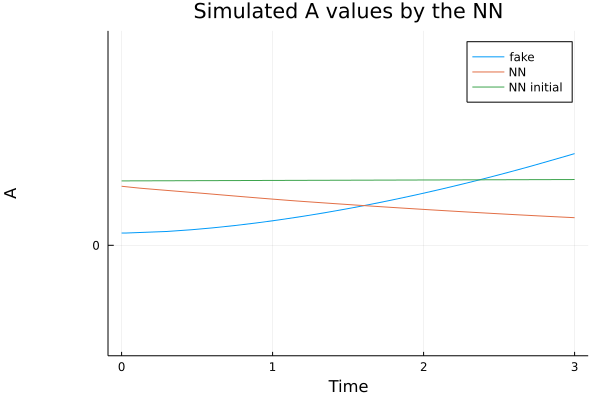

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


In [56]:
all_times = LinRange(0, t₁, 50)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(fakeA, 0, t₁, label="fake")
plot!(all_times, predict_A(UA, all_times')', title="Simulated A values by the NN", yaxis="A", xaxis="Time", label="NN")
plot!(all_times, initial_NN, label="NN initial")

In [60]:
sum(initial_NN) / length(initial_NN)

5.3055437279701337e-17

In [61]:
sum(predict_A(UA, all_times')') / length(all_times)

3.3965091466721485e-17

In [62]:
sum(fakeA.(all_times)) / length(all_times)

3.414564306201394e-17